In [2]:
import sys
sys.path.append('process_data/')
sys.path.append('eval/')

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from pyproj import CRS
import util_data
import util_eval
import util_plot

from setup import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams.update({"font.size":16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
out_folder = '2106_rc_new1/'
out_file = ''

period = 'before'
predict_hzn = 1
lookback = 2

time_size = 4
max_lookback = 6

z = 1.96
difference = True
if difference:
    differenced = "diff"
else:
    differenced = "raw"


In [4]:
dates = pd.read_csv(project_dir+"data/"+period+"_dates.csv")
with open(project_dir+"data/data_processed/rail_catchment/"+period+"/"+
          period+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+differenced+"_data_train.pkl","rb") as f:
    x_train = pkl.load(f)
    ref_train = pkl.load(f)
    los_train = pkl.load(f)
    weather_train = pkl.load(f)
    y_train = pkl.load(f)
    ts_train = pkl.load(f)
    station_id = pkl.load(f)
    
with open(project_dir+"data/data_processed/rail_catchment/"+period+"/"+
          period+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+differenced+"_data_test.pkl","rb") as f:
    x_test = pkl.load(f)
    ref_test = pkl.load(f)
    los_test = pkl.load(f)
    weather_test = pkl.load(f)
    y_test = pkl.load(f)
    ts_test = pkl.load(f)
    
df = pd.DataFrame(np.array([np.concatenate((ts_train, ts_test)), 
                            np.concatenate((np.zeros(len(ts_train)), np.ones(len(ts_test))))]).T, 
                            columns=['ts','train/test'])

In [5]:
x_train.shape

(3136, 6, 141, 3)

In [6]:
with open(project_dir+"data/data_processed/common_stations.pkl", "rb") as f:
    common_stations = pkl.load(f)
stations_mask = np.isin(np.array(station_id), common_stations)

x_train = x_train[:, :, stations_mask,:]
y_train = y_train[:, -1, stations_mask]
x_test = x_test[:, :, stations_mask,:]
y_test = y_test[:, -1, stations_mask]
ref_train = ref_train[:, -1, stations_mask]
ref_test = ref_test[:, -1, stations_mask]
los_train = los_train[:,-1,stations_mask]
los_test = los_test[:,-1,stations_mask]

downtown_stations = pd.read_csv(project_dir+"data/data_processed/downtown_stations.csv")
downtown_filter = np.isin(np.array(station_id)[stations_mask], downtown_stations['STATION_ID'])

In [7]:
ref = np.concatenate((ref_train, ref_test))
y = np.concatenate((y_train, y_test))
ts = np.concatenate((ts_train, ts_test))

In [8]:
# Value to use as the intial value of homoskedastic variation of GCN MVE
np.std(y_train[:, downtown_filter]-ref_train[:, downtown_filter])

460.7943748494359

In [9]:
spatial = pd.read_csv(project_dir+"data/data_processed/rail_catchment/spatial.csv")

#print("All Available Columns:\n", spatial.columns.tolist())

spatial['pct_adults'] = spatial['pct25_34yrs']+spatial['pct35_50yrs']
spatial = spatial[['STATION_ID','tot_population','pct_adults','pctover65yrs',
         'pctPTcommute','avg_tt_to_work','inc_per_capita',
         'entertainment', 'restaurant', 'school', 'shop']]

#print("\n\nColumns included:\n", spatial.columns.tolist())
spatial = spatial.to_numpy()

# update station selections
common_stations = np.intersect1d(common_stations, spatial[:,0])

stations_mask = np.isin(spatial[:,0], common_stations)
spatial = spatial[stations_mask,1:]
# normalize the values that are not percentages
for i in [0,4,5,6,7,8,9]:
    spatial[:,i] = (spatial[:,i] - np.mean(spatial[:,i]))/np.std(spatial[:,i])


# 1. All Zeros

## 1.1 All Stations

In [6]:
tr_mae, tr_mse, tr_nz_mae, tr_nz_mse, tr_pct_nonzeros = \
    util_eval.eval_mean(np.zeros(y_train.shape), y_train, 'Train', stdout=True)
print()
mae, mse, nz_mae, nz_mse, pct_nonzeros = \
    util_eval.eval_mean(np.zeros(y_test.shape), y_test, 'Test', stdout=True)

(Train) Mean Absolute Error: 182.250
(Train) Mean Squared Error: 321831.568
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 182.894
(Train) Mean Squared Error: 322967.501

(Test) Mean Absolute Error: 189.711
(Test) Mean Squared Error: 350362.642
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 190.736
(Test) Mean Squared Error: 352255.357


In [7]:
with open(project_dir+"results/"+out_folder+out_folder,"a") as f:
        f.write("%s,%s,%s,%d,%d,,%.2f,%.2f,,,,,,,%.2f,%.2f\n" % 
                (period, 'all zeros', 'all',
                predict_hzn, time_size, 
                tr_mae, tr_mse, 
                mae, mse))

## 1.2 Downtown Stations

In [8]:
tr_mae, tr_mse, tr_nz_mae, tr_nz_mse, tr_pct_nonzeros = \
    util_eval.eval_mean(np.zeros(y_train[:,downtown_filter].shape), y_train[:,downtown_filter], 'Train', stdout=True)
print()
mae, mse, nz_mae, nz_mse, pct_nonzeros = \
    util_eval.eval_mean(np.zeros(y_test[:,downtown_filter].shape), y_test[:,downtown_filter], 'Test', stdout=True)

(Train) Mean Absolute Error: 583.947
(Train) Mean Squared Error: 2064472.477
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 585.461
(Train) Mean Squared Error: 2069825.981

(Test) Mean Absolute Error: 635.398
(Test) Mean Squared Error: 2276337.740
Percent Nonzeros: 100%
Nonzero Entries:
(Test) Mean Absolute Error: 635.398
(Test) Mean Squared Error: 2276337.740


In [9]:
with open(project_dir+"results/"+out_folder+out_folder,"a") as f:
        f.write("%s,%s,%s,%d,%d,,%.2f,%.2f,,,,,,,%.2f,%.2f\n" % 
                (period, 'all zeros', 'downtown',
                predict_hzn, time_size, 
                tr_mae, tr_mse, 
                mae, mse))

# 2. Past Observations

## 2.1 All Stations

In [10]:
# get variance
emp_std = []
for t in df[df['train/test']==1].ts:
    temp = int(t)
    ref_list = []
    while (temp>0) & (len(ref_list)<20):
        temp = temp - 672
        if int(temp) in ts:
            if dates[dates.index==int(t//(96/time_size))].iloc[0]['holiday'] == dates[dates.index==int(temp//(96/time_size))].iloc[0]['holiday']:
                ref_list.append(y[list(ts).index(int(temp)),:])
    ref_list = np.array(ref_list)
    emp_std.append(np.std(ref_list, axis=0))   
emp_std = np.array(emp_std)

In [12]:
tr_mae, tr_mse, tr_nz_mae, tr_nz_mse, tr_pct_nonzeros = \
    util_eval.eval_mean(np.squeeze(ref_train), y_train, 'Train', stdout=True)
print()
mae, mse, nz_mae, nz_mse, pct_nonzeros = \
    util_eval.eval_mean(np.squeeze(ref_test), y_test, 'Test', stdout=True)

(Train) Mean Absolute Error: 37.526
(Train) Mean Squared Error: 34192.487
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 37.466
(Train) Mean Squared Error: 34245.349

(Test) Mean Absolute Error: 23.694
(Test) Mean Squared Error: 12065.078
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 23.612
(Test) Mean Squared Error: 11962.270


In [13]:
print('(Train)')
tr_u, tr_ub, tr_uv, tr_uc = util_eval.eval_theils(np.squeeze(ref_train), y_train, stdout = True)
print('(Test)')
u, ub, uv, uc = util_eval.eval_theils(np.squeeze(ref_test), y_test, stdout = True)

(Train)
Theil's U: 0.162730
Bias: 0.000033
Variance: 0.000061
Covariance: 0.999906
(Test)
Theil's U: 0.095559
Bias: 0.004778
Variance: 0.094251
Covariance: 0.900971


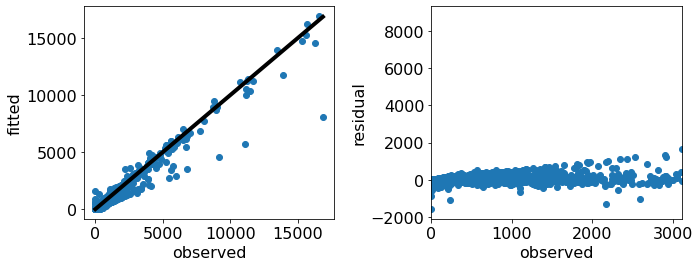

In [14]:
util_plot.plot_fit_res(y_test.flatten(), ref_test.flatten())

In [15]:
z = 1.96

mpiw, picp = util_eval.eval_pi(np.squeeze(ref_test)-z*emp_std,np.squeeze(ref_test)+z*emp_std,y_test)
print("(Test) Mean Prediction Interval: %.2f"%(mpiw))
print("(Test) Coverage Probability: %.4f"%(picp))

(Test) Mean Prediction Interval: 168.27
(Test) Coverage Probability: 0.8862


In [16]:
with open(project_dir+"results/"+out_folder+out_folder,"a") as f:
        f.write("%s,%s,%s,%d,%d,,%.2f,%.2f,%.6f,%.6f,%.6f,%.6f,,,%.2f,%.2f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f\n" % 
                (period, 'last week', 'all',
                predict_hzn, time_size, 
                tr_mae, tr_mse, tr_u, tr_ub, tr_uv, tr_uc, 
                mae, mse, u, ub, uv, uc, mpiw, picp))

## 2.2 Downtown

In [11]:
tr_mae, tr_mse, tr_nz_mae, tr_nz_mse, tr_pct_nonzeros = \
    util_eval.eval_mean(ref_train[:, downtown_filter], y_train[:, downtown_filter], 'Train', stdout=True)
print()
mae, mse, nz_mae, nz_mse, pct_nonzeros = \
    util_eval.eval_mean(ref_test[:, downtown_filter], y_test[:, downtown_filter], 'Test', stdout=True)

(Train) Mean Absolute Error: 113.439
(Train) Mean Squared Error: 212344.145
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 113.632
(Train) Mean Squared Error: 212884.236

(Test) Mean Absolute Error: 71.821
(Test) Mean Squared Error: 78945.209
Percent Nonzeros: 100%
Nonzero Entries:
(Test) Mean Absolute Error: 71.821
(Test) Mean Squared Error: 78945.209


In [12]:
print("(Train)")
tr_u, tr_ub, tr_uv, tr_uc = util_eval.eval_theils(ref_train[:, downtown_filter], y_train[:, downtown_filter], stdout = True)
print("(Test)")
u, ub, uv, uc = util_eval.eval_theils(ref_test[:, downtown_filter], y_test[:, downtown_filter], stdout = True)

(Train)
Theil's U: 0.160111
Bias: 0.000060
Variance: 0.000049
Covariance: 0.999891
(Test)
Theil's U: 0.096111
Bias: 0.013075
Variance: 0.099971
Covariance: 0.886953


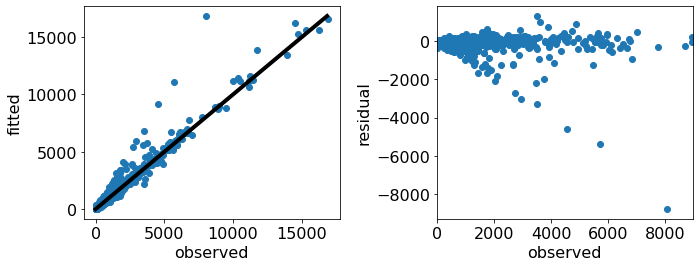

In [19]:
util_plot.plot_fit_res(ref_test[:, downtown_filter], y_test[:, downtown_filter])

In [20]:
z = 1.96

mpiw, picp = util_eval.eval_pi(ref_test[:, downtown_filter]-z*emp_std[:, downtown_filter],
                               ref_test[:, downtown_filter]+z*emp_std[:, downtown_filter],
                               y_test[:, downtown_filter])
print("(Test) Mean Prediction Interval: %.2f"%(mpiw))
print("(Test) Coverage Probability: %.4f"%(picp))

(Test) Mean Prediction Interval: 517.46
(Test) Coverage Probability: 0.8994


In [21]:
with open(project_dir+"results/"+out_folder+out_folder,"a") as f:
        f.write("%s,%s,%s,%d,%d,,%.2f,%.2f,%.6f,%.6f,%.6f,%.6f,,,%.2f,%.2f,%.6f,%.6f,%.6f,%.6f,%.6f,%.6f\n" % 
                (period, 'last week', 'downtown',
                predict_hzn, time_size, 
                tr_mae, tr_mse, tr_u, tr_ub, tr_uv, tr_uc, 
                mae, mse, u, ub, uv, uc, mpiw, picp))

# 3. Linear Regression

In [8]:
from util_wls import WLS 

In [9]:
_,_,n_station,n_mode = x_train.shape

ts_train_daily = (ts_train % (96//time_size))
ntime = len(np.unique(ts_train_daily))
ts_train_daily = np.repeat(ts_train_daily, n_station)
ts_train_onehot = np.zeros((len(ts_train_daily), ts_train_daily.max()+1))
ts_train_onehot[np.arange(ts_train_daily.size),ts_train_daily] = 1
ts_train_onehot = ts_train_onehot[:, np.sum(ts_train_onehot, axis=0) != 0]
assert ts_train_onehot.shape[1] == ntime

ts_test_daily = (ts_test % (96//time_size))
ts_test_daily = np.repeat(ts_test_daily, n_station)
ts_test_onehot = np.zeros((len(ts_test_daily), ts_test_daily.max()+1))
ts_test_onehot[np.arange(ts_test_daily.size),ts_test_daily] = 1
ts_test_onehot = ts_test_onehot[:, np.sum(ts_test_onehot, axis=0) != 0]
assert ts_test_onehot.shape[1] == ntime

n_station = np.sum(downtown_filter)

ts_train_daily = (ts_train % (96//time_size))
ntime = len(np.unique(ts_train_daily))
ts_train_daily = np.repeat(ts_train_daily, n_station)
ts_train_onehot_dt = np.zeros((len(ts_train_daily), ts_train_daily.max()+1))
ts_train_onehot_dt[np.arange(ts_train_daily.size),ts_train_daily] = 1
ts_train_onehot_dt = ts_train_onehot_dt[:, np.sum(ts_train_onehot_dt, axis=0) != 0]
assert ts_train_onehot_dt.shape[1] == ntime

ts_test_daily = (ts_test % (96//time_size))
ts_test_daily = np.repeat(ts_test_daily, n_station)
ts_test_onehot_dt = np.zeros((len(ts_test_daily), ts_test_daily.max()+1))
ts_test_onehot_dt[np.arange(ts_test_daily.size),ts_test_daily] = 1
ts_test_onehot_dt = ts_test_onehot_dt[:, np.sum(ts_test_onehot_dt, axis=0) != 0]
assert ts_test_onehot_dt.shape[1] == ntime

## 3.1 Own History

In [25]:
print("All Stations:\n")
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,:,0:1], 2, 1)
ols_x_test = np.moveaxis(x_test[:,max_lookback-lookback:,:,0:1], 2, 1)
WLS(ols_x_train, ols_x_test, [ref_train], [ref_test], y_train, y_test, model='1', extent='all')
print()
"""WLS(ols_x_train, ols_x_test, [ref_train], [ref_test], y_train, y_test, model='1', extent='all', 
    ts_train_onehot, ts_test_onehot, [4])""";

All Stations:

Sample Size (Train): 420224
Number of Variables: 4

(Train) Mean Absolute Error: 33.232
(Train) Mean Squared Error: 15639.965
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 33.258
(Train) Mean Squared Error: 15682.961

(Test) Mean Absolute Error: 26.150
(Test) Mean Squared Error: 6996.565
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 26.191
(Test) Mean Squared Error: 7013.739
(Train)
Theil's U: 0.111596
Bias: 0.000000
Variance: 0.013927
Covariance: 0.986073
(Test)
Theil's U: 0.072443
Bias: 0.001506
Variance: 0.126523
Covariance: 0.871972

(Test)
Mean Prediction Interval: 4353.68
Coverage Probability: 0.7444



In [26]:
print("Downtown:\n")
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,downtown_filter,0:1], 2, 1)
ols_x_test = np.moveaxis(x_test[:,max_lookback-lookback:,downtown_filter,0:1], 2, 1)
WLS(ols_x_train, ols_x_test, 
    [ref_train[:, downtown_filter]], 
    [ref_test[:, downtown_filter]], 
    y_train[:, downtown_filter], y_test[:, downtown_filter],
    model='1', extent='downtown');

Downtown:

Sample Size (Train): 56448
Number of Variables: 4

(Train) Mean Absolute Error: 94.603
(Train) Mean Squared Error: 95834.642
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 94.765
(Train) Mean Squared Error: 96077.618

(Test) Mean Absolute Error: 72.749
(Test) Mean Squared Error: 43092.301
Percent Nonzeros: 100%
Nonzero Entries:
(Test) Mean Absolute Error: 72.749
(Test) Mean Squared Error: 43092.301
(Train)
Theil's U: 0.109008
Bias: 0.000000
Variance: 0.014302
Covariance: 0.985698
(Test)
Theil's U: 0.070573
Bias: 0.005346
Variance: 0.137434
Covariance: 0.857220

(Test)
Mean Prediction Interval: 364.77
Coverage Probability: 0.7489


## 3.2 History of All Modes

In [27]:
print("All Stations: \n")
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,:,:], 2, 1)
ols_x_test = np.moveaxis(x_test[:,max_lookback-lookback:,:,:], 2, 1)
WLS(ols_x_train, ols_x_test, 
    [ref_train], [ref_test], 
    y_train, y_test, 
    model='2', extent='all');

All Stations: 

Sample Size (Train): 420224
Number of Variables: 8

(Train) Mean Absolute Error: 33.659
(Train) Mean Squared Error: 15307.054
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 33.689
(Train) Mean Squared Error: 15350.456

(Test) Mean Absolute Error: 26.983
(Test) Mean Squared Error: 7178.296
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 27.046
(Test) Mean Squared Error: 7197.028
(Train)
Theil's U: 0.110372
Bias: 0.000000
Variance: 0.013623
Covariance: 0.986377
(Test)
Theil's U: 0.073539
Bias: 0.004190
Variance: 0.139600
Covariance: 0.856211

(Test)
Mean Prediction Interval: 4167.14
Coverage Probability: 0.7392


In [10]:
print("Downtown:\n")
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,downtown_filter,:], 2, 1)
ols_x_test = np.moveaxis(x_test[:,max_lookback-lookback:,downtown_filter,:], 2, 1)
ols_y_test_predict, _,_ = WLS(ols_x_train, ols_x_test, 
    [ref_train[:, downtown_filter]], 
    [ref_test[:, downtown_filter]], 
    y_train[:, downtown_filter], y_test[:, downtown_filter],     
    model='2', extent='downtown');

Downtown:

Sample Size (Train): 56448
Number of Variables: 8

(Train) Mean Absolute Error: 99.048
(Train) Mean Squared Error: 93249.416
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 99.201
(Train) Mean Squared Error: 93473.358
(Test) Mean Absolute Error: 78.354
(Test) Mean Squared Error: 44667.709
Percent Nonzeros: 100%
Nonzero Entries:
(Test) Mean Absolute Error: 78.354
(Test) Mean Squared Error: 44667.709
(Train)
Theil's U: 0.107492
Bias: 0.000000
Variance: 0.013905
Covariance: 0.986095
(Test)
Theil's U: 0.072049
Bias: 0.018434
Variance: 0.141270
Covariance: 0.840296

(Train)
Mean Prediction Interval: 390.61
Coverage Probability: 0.6991

(Test)
Mean Prediction Interval: 330.07
Coverage Probability: 0.7410


In [16]:
ols_y_test_predict.shape

(3150,)

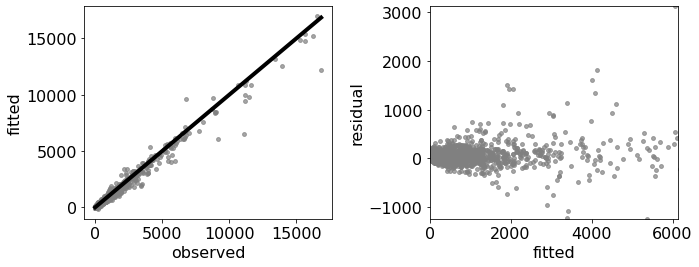

In [34]:
util_plot.plot_fit_res(y_test[:, downtown_filter].flatten(), ols_y_test_predict)

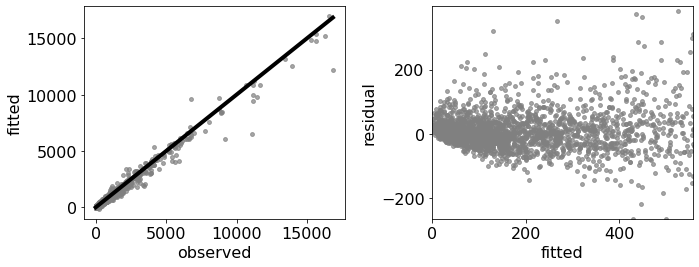

In [35]:
util_plot.plot_fit_res(y_test[:, downtown_filter].flatten(), ols_y_test_predict)

## 3.3 +LOS

In [29]:
print("All Stations: \n")
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,:,:], 2, 1)
ols_x_test = np.moveaxis(x_test[:,max_lookback-lookback:,:,:], 2, 1)
WLS(ols_x_train, ols_x_test, [ref_train, los_train], [ref_test, los_test], y_train, y_test, model='3', extent='all');
#print("\nTime specific LOS Coefs\n")
#WLS(ols_x_train, ols_x_test, [ref_train, los_train], [ref_test, los_test], y_train, y_test, model='3+', extent='all', 
#    ts_train_onehot=ts_train_onehot, ts_test_onehot=ts_test_onehot, time_specific_coefs=[lookback*n_mode+1])


All Stations: 

Sample Size (Train): 420224
Number of Variables: 9

(Train) Mean Absolute Error: 34.662
(Train) Mean Squared Error: 14899.126
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 34.529
(Train) Mean Squared Error: 14918.367

(Test) Mean Absolute Error: 27.645
(Test) Mean Squared Error: 7168.364
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 27.543
(Test) Mean Squared Error: 7166.805
(Train)
Theil's U: 0.108856
Bias: 0.000000
Variance: 0.013250
Covariance: 0.986750
(Test)
Theil's U: 0.073504
Bias: 0.004210
Variance: 0.142141
Covariance: 0.853649

(Test)
Mean Prediction Interval: 1996.30
Coverage Probability: 0.7435


In [30]:
print("Downtown:\n")
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,downtown_filter,:], 2, 1)
ols_x_test = np.moveaxis(x_test[:,max_lookback-lookback:,downtown_filter,:], 2, 1)
WLS(ols_x_train, ols_x_test, [ref_train[:, downtown_filter], los_train[:, downtown_filter]], 
    [ref_test[:, downtown_filter], los_test[:, downtown_filter]], 
    y_train[:, downtown_filter], y_test[:, downtown_filter],
    model='3', extent='downtown');
'''
WLS(ols_x_train, ols_x_test, [ref_train[:, downtown_filter], los_train[:, downtown_filter]], 
    [ref_test[:, downtown_filter], los_test[:, downtown_filter]], 
    y_train[:, downtown_filter], y_test[:, downtown_filter],
    model='3+', extent='downtown',
    ts_train_onehot=ts_train_onehot_dt, ts_test_onehot=ts_test_onehot_dt, time_specific_coefs=[lookback*n_mode+1])
''';

Downtown:

Sample Size (Train): 56448
Number of Variables: 9

(Train) Mean Absolute Error: 100.358
(Train) Mean Squared Error: 89727.723
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 100.088
(Train) Mean Squared Error: 89798.428

(Test) Mean Absolute Error: 77.182
(Test) Mean Squared Error: 44721.823
Percent Nonzeros: 100%
Nonzero Entries:
(Test) Mean Absolute Error: 77.182
(Test) Mean Squared Error: 44721.823
(Train)
Theil's U: 0.105397
Bias: 0.000000
Variance: 0.013366
Covariance: 0.986634
(Test)
Theil's U: 0.072110
Bias: 0.016369
Variance: 0.146758
Covariance: 0.836873

(Test)
Mean Prediction Interval: 311.91
Coverage Probability: 0.7479


## 3.4 +demo

In [31]:
print("All Stations: \n")
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,:,:], 2, 1)
ols_x_test = np.moveaxis(x_test[:,max_lookback-lookback:,:,:], 2, 1)
spatial_train = np.tile(spatial[np.newaxis,:,:], (len(ols_x_train),1,1))
spatial_test = np.tile(spatial[np.newaxis,:,:], (len(ols_x_test),1,1))
WLS(ols_x_train, ols_x_test, [ref_train, los_train, spatial_train], [ref_test, los_test, spatial_test], 
    y_train, y_test,
    model='4', extent='all');


All Stations: 

Sample Size (Train): 420224
Number of Variables: 19

(Train) Mean Absolute Error: 34.709
(Train) Mean Squared Error: 14871.931
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 34.577
(Train) Mean Squared Error: 14891.712

(Test) Mean Absolute Error: 27.480
(Test) Mean Squared Error: 7160.848
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 27.379
(Test) Mean Squared Error: 7159.893
(Train)
Theil's U: 0.108754
Bias: 0.000000
Variance: 0.013225
Covariance: 0.986775
(Test)
Theil's U: 0.073463
Bias: 0.004221
Variance: 0.141812
Covariance: 0.853967

(Test)
Mean Prediction Interval: 163.81
Coverage Probability: 0.7466


In [32]:
print("Downtown: \n")
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,downtown_filter,:], 2, 1)
ols_x_test = np.moveaxis(x_test[:,max_lookback-lookback:,downtown_filter,:], 2, 1)
spatial_train = np.tile(spatial[np.newaxis,downtown_filter,:], (len(ols_x_train),1,1))
spatial_test = np.tile(spatial[np.newaxis,downtown_filter,:], (len(ols_x_test),1,1))
WLS(ols_x_train, ols_x_test, [ref_train[:, downtown_filter], los_train[:, downtown_filter], spatial_train], 
    [ref_test[:, downtown_filter], los_test[:, downtown_filter], spatial_test], 
    y_train[:, downtown_filter], y_test[:, downtown_filter],
    model='4', extent='downtown');

Downtown: 

Sample Size (Train): 56448
Number of Variables: 19

(Train) Mean Absolute Error: 100.457
(Train) Mean Squared Error: 89522.780
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 100.182
(Train) Mean Squared Error: 89589.717

(Test) Mean Absolute Error: 77.371
(Test) Mean Squared Error: 44699.528
Percent Nonzeros: 100%
Nonzero Entries:
(Test) Mean Absolute Error: 77.371
(Test) Mean Squared Error: 44699.528
(Train)
Theil's U: 0.105273
Bias: 0.000000
Variance: 0.013334
Covariance: 0.986666
(Test)
Theil's U: 0.072091
Bias: 0.016511
Variance: 0.146419
Covariance: 0.837070

(Test)
Mean Prediction Interval: 244.60
Coverage Probability: 0.7429


## 3.4 + Weather

In [33]:
print("All Stations: \n")
_,_,n_station,_ = x_train.shape
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,:,:], 2, 1)
ols_x_test = np.moveaxis(x_test[:,max_lookback-lookback:,:,:], 2, 1)
ols_weather_train = np.tile(weather_train[:,np.newaxis,:], (1,n_station,1))
ols_weather_test = np.tile(weather_test[:,np.newaxis,:], (1,n_station,1))
spatial_train = np.tile(spatial[np.newaxis,:,:], (len(ols_x_train),1,1))
spatial_test = np.tile(spatial[np.newaxis,:,:], (len(ols_x_test),1,1))

WLS(ols_x_train, ols_x_test, [ref_train, los_train, spatial_train, ols_weather_train], 
    [ref_test, los_test, spatial_test, ols_weather_test], y_train, y_test,
    model='5', extent='all');

All Stations: 

Sample Size (Train): 420224
Number of Variables: 21

(Train) Mean Absolute Error: 34.735
(Train) Mean Squared Error: 14866.903
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 34.602
(Train) Mean Squared Error: 14886.447

(Test) Mean Absolute Error: 27.522
(Test) Mean Squared Error: 7176.235
Percent Nonzeros: 99%
Nonzero Entries:
(Test) Mean Absolute Error: 27.421
(Test) Mean Squared Error: 7175.114
(Train)
Theil's U: 0.108735
Bias: 0.000000
Variance: 0.013220
Covariance: 0.986780
(Test)
Theil's U: 0.073565
Bias: 0.005854
Variance: 0.141906
Covariance: 0.852240

(Test)
Mean Prediction Interval: 161.09
Coverage Probability: 0.7383


In [34]:
print("Downtown:\n")
n_station = np.sum(downtown_filter)
ols_x_train = np.moveaxis(x_train[:,max_lookback-lookback:,downtown_filter,:], 2, 1)
ols_x_test = np.moveaxis(x_test[:,max_lookback-lookback:,downtown_filter,:], 2, 1)
ols_weather_train = np.tile(weather_train[:,np.newaxis,:], (1,n_station,1))
ols_weather_test = np.tile(weather_test[:,np.newaxis,:], (1,n_station,1))
spatial_train = np.tile(spatial[np.newaxis,downtown_filter,:], (len(ols_x_train),1,1))
spatial_test = np.tile(spatial[np.newaxis,downtown_filter,:], (len(ols_x_test),1,1))

ols_pred_test, ols_pred_std_test = WLS(ols_x_train, ols_x_test, 
    [ref_train[:, downtown_filter], los_train[:, downtown_filter], spatial_train, ols_weather_train], 
    [ref_test[:, downtown_filter], los_test[:, downtown_filter], spatial_test, ols_weather_test], 
    y_train[:, downtown_filter], y_test[:, downtown_filter],
    model='5', extent='downtown');

Downtown:

Sample Size (Train): 56448
Number of Variables: 21

(Train) Mean Absolute Error: 100.744
(Train) Mean Squared Error: 89435.022
Percent Nonzeros: 99%
Nonzero Entries:
(Train) Mean Absolute Error: 100.467
(Train) Mean Squared Error: 89501.895

(Test) Mean Absolute Error: 77.938
(Test) Mean Squared Error: 44933.527
Percent Nonzeros: 100%
Nonzero Entries:
(Test) Mean Absolute Error: 77.938
(Test) Mean Squared Error: 44933.527
(Train)
Theil's U: 0.105221
Bias: 0.000000
Variance: 0.013321
Covariance: 0.986679
(Test)
Theil's U: 0.072324
Bias: 0.021128
Variance: 0.146604
Covariance: 0.832268

(Test)
Mean Prediction Interval: 238.87
Coverage Probability: 0.7356


In [35]:
with open(project_dir+'results/'+out_folder+'/'+period+'_dt_benchmark.pkl', 'wb') as f:
    pkl.dump(ref_test[:, downtown_filter], f)
    pkl.dump(emp_std[:, downtown_filter], f)
    pkl.dump(ols_pred_test.reshape(emp_std[:,downtown_filter].shape), f)
    pkl.dump(ols_pred_std_test.reshape(emp_std[:,downtown_filter].shape), f)